# Regularization for linear classifier models

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, mean_absolute_error

from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import matplotlib as mpl

%config InlineBackend.figure_format = 'svg'

def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    return np.mean(train_scores), np.mean(test_scores)

def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        X[colname] = (X[colname] - u) / s
    return X

In [2]:
def plot_coef(B):
    plt.figure(figsize=(3,3))
    plt.bar(range(len(B)),B)
    plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
    plt.ylabel("Regression coefficient value", fontsize=12)

## Wine data for classes 0,1

In [3]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}
X = df_wine.drop('y', axis=1)

# Try with first 3 features
#X = X.iloc[:,0:3]

y = df_wine['y']
print(f"{len(X)} records for classes {{0,1}} from {len(wine.data)} records")

130 records for classes {0,1} from 178 records


In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Baseline sklearn no reg

In [6]:
lm = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 0.9615384615384616)

In [7]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(5.619343599575202e-09, 1.328414476727335)

In [8]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(5.6193416675924775e-09, 0.038461538461538464)

In [9]:
lm.coef_[0]

array([ 5.31181547e+03, -6.10873064e+03, -4.02088922e+03,  8.28148121e+02,
        3.96531082e-01,  7.07846401e+02, -2.66720955e+03, -2.48870771e+02,
        1.95420710e+03, -3.46512526e+03,  1.21248454e+03, -1.86044058e+03,
       -5.68232504e+01])

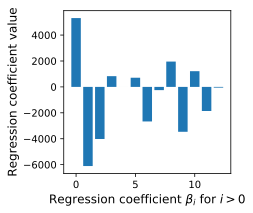

In [10]:
plot_coef(lm.coef_[0])
#plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.1f}'))

## normalize and try again

In [11]:
X_train = normalize(X_train)
X_test = normalize(X_test)

lm = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 0.9615384615384616)

In [12]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(1.0319931417042478e-06, 0.3719216993895669)

In [13]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(1.031984752325603e-06, 0.03860345767843984)

In [14]:
lm.coef_[0]

array([-9.88789019, -1.79510099, -6.59478201,  8.33853144, -1.29591602,
       -1.92324777,  1.3336937 , -1.58078576,  0.89671131, -4.19345871,
        2.51375037, -4.41016556, -9.6571536 ])

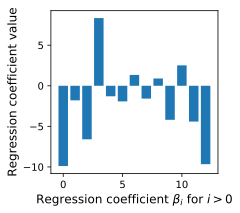

In [15]:
plot_coef(lm.coef_[0])
#plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.9f}'))

### With reg

In [16]:
lm = LogisticRegression(C=1/.5, penalty='l1', solver='liblinear', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 0.9615384615384616)

In [17]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(0.017465394083566507, 0.06389603818831509)

In [18]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(0.01667096336387652, 0.04413262879744214)

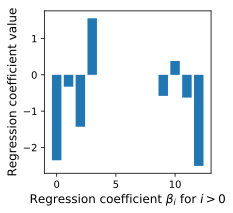

In [19]:
plot_coef(lm.coef_[0])

## Increase lambda

In [20]:
lm = LogisticRegression(C=1/5, penalty='l1', solver='liblinear', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(0.9903846153846154, 0.9615384615384616)

In [21]:
log_loss(y_train, lm.predict_proba(X_train)), log_loss(y_test, lm.predict_proba(X_test))

(0.12625075069093927, 0.14436554246610053)

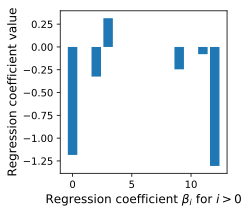

In [22]:
plot_coef(lm.coef_[0])

We pushed coefficients to 0 by increasing $lambda$ (inverse of C)

## MNIST classification

In [23]:
digits = pd.read_csv("../../data/mnist-10k-sample.csv")
images = digits.drop('digit', axis=1) # get just pixels
targets = digits['digit']             # get just digit value

In [24]:
def imgrid(images,targets):
    fig, axes = plt.subplots(5, 5, figsize=(4, 4)) # make 5x5 grid of plots
    for i, ax in enumerate(axes.flat):
        img_as_row = images.iloc[i].values
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, targets[i], color='#313695', fontsize=18)

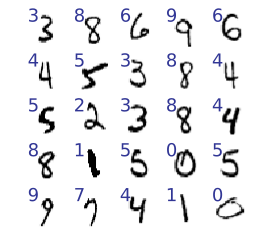

In [25]:
imgrid(images,targets=targets)

In [26]:
zeros  = images[targets==0] # find all "0" images
ones   = images[targets==1] # find all "1" images
sevens = images[targets==7] # find all "7" images
fours = images[targets==4] # find all "4" images
nines = images[targets==9] # find all "9" images

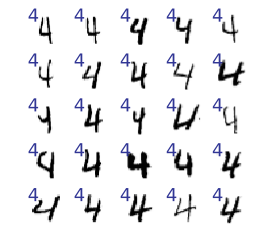

In [27]:
imgrid(fours, targets[targets==4].values)

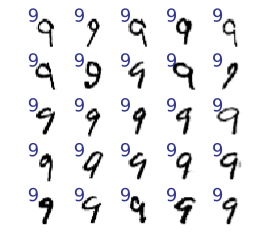

In [28]:
imgrid(nines, targets[targets==9].values)

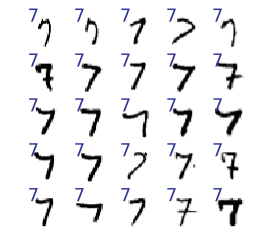

In [29]:
imgrid(sevens, targets[targets==7].values)

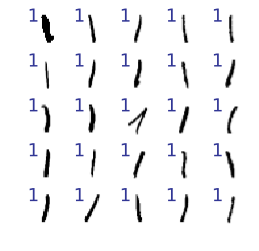

In [30]:
imgrid(ones, targets[targets==1].values)

In [31]:
np.unique(ones.iloc[1]) # greyscale values 0..1

array([0.        , 0.04296875, 0.05078125, 0.09375   , 0.09765625,
       0.140625  , 0.15625   , 0.16015625, 0.171875  , 0.27734375,
       0.296875  , 0.30078125, 0.37109375, 0.375     , 0.41015625,
       0.46484375, 0.4765625 , 0.52734375, 0.54296875, 0.546875  ,
       0.58203125, 0.5859375 , 0.6484375 , 0.66015625, 0.73046875,
       0.7578125 , 0.76171875, 0.76953125, 0.7890625 , 0.796875  ,
       0.80078125, 0.82421875, 0.8359375 , 0.8515625 , 0.890625  ,
       0.93359375, 0.96875   , 0.9765625 , 0.98046875, 0.9921875 ])

In [32]:
# combine 4s and 9s to get subset of data; fours' class is 0, nines' class is 1
print(f"{len(fours)} fours and {len(nines)} nines")
X = np.concatenate([fours, nines], axis=0)
y = np.concatenate([np.zeros(len(fours)), np.ones(len(nines))], axis=0)

983 fours and 961 nines


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Fit model

In [34]:
lgr = LogisticRegression(penalty='none', solver='lbfgs')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(1.0, 0.9562982005141388)

In [35]:
log_loss(y_train, lgr.predict_proba(X_train)[:,1]), log_loss(y_test, lgr.predict_proba(X_test)[:,1])

(1.249358434628897e-07, 0.8847175564181347)

In [36]:
mean_absolute_error(y_train, lgr.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lgr.predict_proba(X_test)[:,1])

(1.2493522607478306e-07, 0.043199163670709265)

What the predictions should be (0=one, 1=seven)

### Evaluating results

What we get (all class 0 or "ones"). dang.

In [37]:
y_pred = lgr.predict(X_test)
np.sum(np.array(y_pred) != np.array(y_test)), len(y_pred)

(17, 389)

In [38]:
sum(np.abs(lgr.coef_[0]) < 1e-5) # how many close to 0?

238

Text(0, 0.5, 'Regression coefficient value')

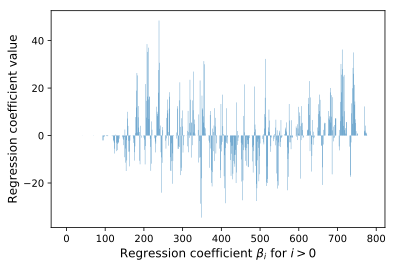

In [39]:
plt.bar(range(len(lgr.coef_[0,:])),lgr.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)
#plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.8f}'))

In [40]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
P = precision_score(y_test, y_pred)
R = recall_score(y_test, y_pred)
P, R

[[179   7]
 [ 10 193]]


(0.965, 0.9507389162561576)

## L1 Regularization

In [41]:
for lmbda in [1e-7, 0.001, 1, 5, 10, 100, 150]:
    lm = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    print(f"lambda={lmbda:>11} gets training accuracy {lm.score(X_train, y_train):.2f} & testing {lm.score(X_test, y_test):.2f} precision={P:.2f}, recall={R:.2f}")

lambda=      1e-07 gets training accuracy 1.00 & testing 0.96 precision=0.96, recall=0.95
lambda=      0.001 gets training accuracy 1.00 & testing 0.97 precision=0.98, recall=0.97
lambda=          1 gets training accuracy 0.99 & testing 0.96 precision=0.98, recall=0.95
lambda=          5 gets training accuracy 0.97 & testing 0.96 precision=0.98, recall=0.94
lambda=         10 gets training accuracy 0.96 & testing 0.95 precision=0.96, recall=0.94
lambda=        100 gets training accuracy 0.88 & testing 0.88 precision=0.87, recall=0.90
lambda=        150 gets training accuracy 0.88 & testing 0.90 precision=0.86, recall=0.96


In [42]:
lmbda=1
lm = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
lm.fit(X_train, y_train)
sum(np.abs(lm.coef_[0]) < 1e-5) # how many close to 0?

681

In [43]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(0.04765562146871921, 0.1012939479469668)

In [44]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(0.03772232065376669, 0.05543803810548862)

Text(0, 0.5, 'Regression coefficient value')

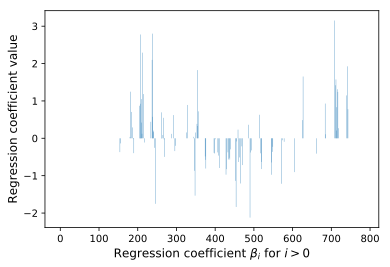

In [45]:
plt.bar(range(len(lm.coef_[0,:])),lm.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)

## L2 Regularization

In [46]:
for lmbda in [1e-7, 0.001, 1, 5, 10, 100, 150]:
    lm = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    print(f"lambda={lmbda:>11} gets training accuracy {lm.score(X_train, y_train):.2f} & testing {lm.score(X_test, y_test):.2f} precision={P:.2f}, recall={R:.2f}")

lambda=      1e-07 gets training accuracy 1.00 & testing 0.97 precision=0.98, recall=0.96
lambda=      0.001 gets training accuracy 1.00 & testing 0.97 precision=0.98, recall=0.96
lambda=          1 gets training accuracy 0.99 & testing 0.97 precision=0.98, recall=0.96
lambda=          5 gets training accuracy 0.98 & testing 0.97 precision=0.98, recall=0.95
lambda=         10 gets training accuracy 0.98 & testing 0.97 precision=0.98, recall=0.95
lambda=        100 gets training accuracy 0.96 & testing 0.95 precision=0.96, recall=0.95
lambda=        150 gets training accuracy 0.96 & testing 0.95 precision=0.96, recall=0.95


In [47]:
lmbda=1
lm = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
lm.fit(X_train, y_train)
sum(np.abs(lm.coef_[0]) < 1e-5) # how many close to 0?

239

In [48]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(0.03562250359078159, 0.08045927486998841)

In [49]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(0.02986339228737083, 0.04757680138355935)

Text(0, 0.5, 'Regression coefficient value')

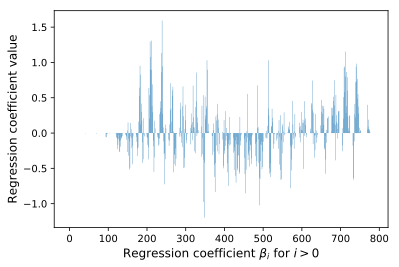

In [50]:
plt.bar(range(len(lm.coef_[0,:])),lm.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)

## Breast cancer 

In [51]:
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df_cancer['y'] = cancer.target
X = df_cancer.drop('y', axis=1)
y = df_cancer['y']
X.shape

(569, 30)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [53]:
lgr = LogisticRegression(penalty='none', solver='lbfgs')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

/Users/parrt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.9648351648351648, 0.9122807017543859)

In [54]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.08519987551191062, 0.1927613218317096)

In [55]:
sum(np.abs(lm.coef_[0]) < 1e-5) # how many close to 0?

239

In [56]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [57]:
lmbda=1
lgr = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.9912087912087912, 0.9824561403508771)

In [58]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.055992077379024036, 0.07758093716253826)

In [59]:
sum(np.abs(lgr.coef_[0]) < 1e-5) # how many close to 0?

14

In [60]:
lmbda=1
lgr = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.989010989010989, 0.9736842105263158)

In [61]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.05517673410533195, 0.07466474256299956)

In [62]:
sum(np.abs(lgr.coef_[0]) < 1e-5) # how many close to 0?

0

## Paribas

In [63]:
df_par = pd.read_csv("paribas.csv")
df_par = df_par.sample(20_000)
df_par.shape

(20000, 133)

In [64]:
numcols = df_par.columns[[is_numeric_dtype(df_par[c]) for c in df_par.columns]]
df_par = df_par[numcols]
df_par = df_par.dropna(0)
df_par.shape

(10945, 114)

In [65]:
df_par.head(1)

,ID,target,v1,v2,v4,v5,v6,v7,v8,v9,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
91621,183163,1,1.716576,4.028264,4.620809,9.567552,3.728384,2.589625,1.992404,6.947368,...,3.820754,5.403508,3.87337,0.38029,1.576214,4.064741,2.084614,0,2.175895,1.317366


In [66]:
X = df_par.drop('target', axis=1)
y = df_par['target']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
lgr = LogisticRegression(penalty='none', solver='lbfgs')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.7614207400639561, 0.754682503426222)

In [69]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.5480250650447722, 0.5553984663360196)

In [70]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [71]:
lmbda=0.00001
lgr = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

/Users/parrt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(0.7646185472818638, 0.7514846962083143)

In [72]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.4983024343024925, 0.5230924915634225)

In [73]:
lmbda=10
lgr = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.7631338510735496, 0.754682503426222)

In [74]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.4999135265199019, 0.5132183061597704)